## Exercise Sheet 7: Variational Autoencoders

In [1]:
import os
import random
import time
import numpy as np
import seaborn as sns

# Import Pytorch, Sklearn
from sklearn.manifold import TSNE
import torch 
import torch.nn as nn
from torch.nn import functional as F

# Load FashionMNIST dataset
from torchvision import datasets, transforms


import matplotlib.pyplot as plt; plt.rcdefaults()
%matplotlib inline

# set figure size
plt.figure(figsize=(10, 5))

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

In [2]:
# set random seed
random.seed(42)
torch.manual_seed(42)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

########################
##### HOUSEKEEPING #####

# set hyperparameters
config_dict = {
    'num_epochs': 5,
    'batch_size': 128,
    'latent_dim': 64,
    'learning_rate': 1e-3,
    'weight_decay': 1e-5,
    'mse_weight': 1.0,
    'kl_weight': 0.0001,
    'ckpt_path': 'vae.pth',
    'mode': 'train', # train or test
}

EPOCHS = 5
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5

# set directories
RESULTS_DIR = 'results/'
DATA_DIR = 'data/'
MODEL_DIR = 'models/'

########################
########################

# if don't exist, create directories
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

Using device: cpu


### Define Variational Autoencoder Architecture

In [3]:
class VAE(nn.Module):

    def __init__(self, num_channels=1, num_classes=10, latent_dim=2, embed_dim=16):
        super(VAE, self).__init__()
        
        self.latent_dim = latent_dim
        self.embed_dim = embed_dim

        # Embedding layer
        self.embedding = nn.Embedding(num_embeddings=num_classes, embedding_dim=embed_dim)

        # Encoder
        self.encoder = nn.ModuleList([
            nn.Conv2d(in_channels=num_channels, out_channels=8, kernel_size=3, stride=2, padding=1),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
        ])

        # Decoder
        self.decoder = nn.ModuleList([
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3),
            nn.Conv2d(in_channels=8, out_channels=num_channels, kernel_size=3, padding=1),
        ])

        # Fully connected layers for learning representations
        self.fc_latent = nn.Linear(in_features=self.latent_dim + self.embed_dim, out_features=512, bias=True)
        self.fc_mean = nn.Linear(in_features=512 + self.embed_dim, out_features=self.latent_dim, bias=True)
        self.fc_var = nn.Linear(in_features=512 + self.embed_dim, out_features=self.latent_dim, bias=True)

        # Activation functions
        self.leaky_relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x, y):
        """
        Args:
            x (tensor): Image(s) of shape [B, C, H, W].
            y (tensor): Class label(s) of shape [B,].

        Returns:
            mean (tensor): Mean of shape [B, latent_dim]. 
            log_var (tensor): Log variance of shape [B, latent_dim].
        """
        # Encoder network
        for layer in self.encoder:
            x = layer(x)
            x = self.leaky_relu(x)

        # Flatten
        x = torch.reshape(x, (x.shape[0], -1))
        # Fully connected layers
        class_embed = self.embedding(y)
        # Concat class information
        mean = self.fc_mean(torch.cat((x, class_embed), dim=1))
        log_var = self.fc_var(torch.cat((x, class_embed), dim=1))
        return mean, log_var

    def decode(self, z, y):
        """
        Args:
            z (tensor): Latent variable(s) of shape [B, latent_dim].
            y (tensor): Class label(s) of shape [B,].

        Returns:
            x (tensor): Reconstructed image(s) of shape [B, C, H, W].
        """
        class_embed = self.embedding(y)
        # Concat class information
        x = self.fc_latent(torch.cat((z, class_embed), dim=1))
        x = torch.reshape(x, (-1, 32, 4, 4))
        for layer in self.decoder:
            x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
            x = self.leaky_relu(x)
            x = layer(x)
        x = self.sigmoid(x)
        return x

    def forward(self, x, y):
        """
        Args:
            x (tensor): Image(s) of shape [B, C, H, W].
            y (tensor): Class label(s) of shape [B,].

        Returns:
            x_recon (tensor): Reconstructed image(s) of shape [B, C, H, W].
            mean (tensor): Mean of shape [B, latent_dim]. 
            log_var (tensor): Log variance of shape [B, latent_dim].
        """
        mean, log_var = self.encode(x, y)
        # Reparameterization Trick
        eps = torch.randn(log_var.shape, device=log_var.device)
        z = mean + torch.exp(log_var * 0.5) * eps
        x_recon = self.decode(z, y)
        return x_recon, mean, log_var
    
    def sample(self, y, device):
        """
        Args:
            y (int): Class label.
            device (torch.device): Which device to use (cuda or cpu).

        Returns:
            (tensor): Image of shape [1, C, H, W].
        """
        z = torch.randn((1, self.latent_dim), device=device)
        return self.decode(z, torch.tensor([y], device=device))

    def sample_latent(self, x, y):
        """
        Args:
            x (tensor): Image(s) of shape [B, C, H, W].
            y (tensor): Class label(s) of shape [B,].

        Returns:
            z (tensor): Latent variable(s) of shape [B, latent_dim].
        """
        mean, log_var = self.encode(x, y)
        # Reparameterization Trick
        eps = torch.randn(log_var.shape, device=log_var.device)
        z = mean + torch.exp(log_var * 0.5) * eps
        return z

### Task 1: Training a Variational Autoencoder on MNIST

In [4]:
# Task 1.1 Download the MNIST dataset
mean = (0.1307,)
std = (0.3081,)

# Define the transformation
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((28, 28)),
        transforms.RandomRotation(5),
        transforms.Normalize(mean, std)
    ])

# Download and load the training dataset
trainset = datasets.MNIST(DATA_DIR, download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

# Download and load the test dataset
testset = datasets.MNIST(DATA_DIR, download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

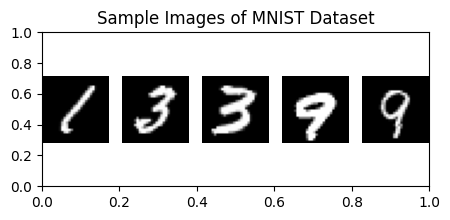

<Figure size 640x480 with 0 Axes>

In [5]:
num_images = 5

# Plot the images from trainloader
plt.figure(figsize=(num_images, 2))
plt.title('Sample Images of MNIST Dataset')
# place it on GPU if available
dataiter = iter(trainloader) 
for i in range(num_images):
    # Get the next batch of images
    images, _ = next(dataiter)

    # Plot the first image in the batch
    plt.subplot(1, num_images, i + 1)
    plt.imshow(images[0].numpy().squeeze(), cmap='gray')
    plt.axis('off')

plt.show()
plt.savefig(RESULTS_DIR + 'mnist_dataset_images.png')

In [6]:
# Task 1.1 Write pytorch code for loss function (BCE + KL Divergence)
#          L(x(i),θ,φ) = −Ez ∼qφ(z|x(i))[log pθ(x(i)|z)] + DKL(qφ(z|x(i)) ∥pθ(z))

def vae_loss(x, x_recon, mean, log_var, mse_weight=1., kl_weight=1e-3):
    """
    Args:
        x (tensor): Image(s) of shape [B, C, H, W].
        x_recon (tensor): Reconstructed image(s) of shape [B, C, H, W].
        mean (tensor): Mean of shape [B, latent_dim]. 
        log_var (tensor): Log variance of shape [B, latent_dim].

    Returns:
        loss (tensor): Loss value.
    """
    # Ensure the input and output are of the same shape
    assert x.shape == x_recon.shape, "x and x_recon must have the same shape"
    
    # Mean Squared Error Loss
    mse = torch.square(x - x_recon)
    # KL Divergence Loss
    kl_div = 0.5 * torch.sum(torch.exp(log_var) + torch.square(mean) - log_var - 1, dim=1)
    loss = mse_weight * torch.mean(mse) + kl_weight * torch.mean(kl_div)
    return loss

In [7]:
def reconstruction_loss(x, x_recon):
    """
    Args:
        x (tensor): Image(s) of shape [B, C, H, W].
        x_recon (tensor): Reconstructed image(s) of shape [B, C, H, W].
        mean (tensor): Mean of shape [B, latent_dim]. 
        log_var (tensor): Log variance of shape [B, latent_dim].

    Returns:
        loss (tensor): Loss value.
    """
    # Ensure the input and output are of the same shape
    assert x.shape == x_recon.shape, "x and x_recon must have the same shape"
    
    # MSE Loss -- Reconstruction loss
    mse = torch.mean((x - x_recon) ** 2)
    return torch.mean(mse)

In [8]:
# Task 1.1 Write pytorch code for loss function (BCE + KL Divergence)
#          L(x(i),θ,φ) = −Ez ∼qφ(z|x(i))[log pθ(x(i)|z)] + DKL(qφ(z|x(i)) ∥pθ(z))

def regularization_loss(mean, log_var):
    """
    Args:
        x (tensor): Image(s) of shape [B, C, H, W].
        x_recon (tensor): Reconstructed image(s) of shape [B, C, H, W].
        mean (tensor): Mean of shape [B, latent_dim]. 
        log_var (tensor): Log variance of shape [B, latent_dim].

    Returns:
        loss (tensor): Loss value.
    """
    kl_div = 0.5 * torch.sum(torch.exp(log_var) + torch.square(mean) - log_var - 1, dim=1)
    return torch.mean(kl_div)

In [9]:
# Task 1.2 Implement the VAE model
vae = VAE(latent_dim=2).to(device)

# Implement the ADAM optimizer
optimizer = torch.optim.Adam(vae.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [10]:
def train(model, optimizer, epochs, trainloader, device, loss_type='total_loss'):
    """
    Train VAE model and plot sample image per class after each epoch.

    Args:
        model (nn.Module): VAE model.
        optimizer (torch.optim): Optimizer.
        epochs (int): Number of epochs.
        trainloader (DataLoader): Training data loader.
        device (torch.device): Which device to use (cuda or cpu).
    
    Returns:
        None
    """
    training_losses = []

    model.train()
    for epoch in range(epochs):
        for step, (images, labels) in enumerate(trainloader):
            x = images.to(device)
            y = labels.to(device)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            x_recon, mean, log_var = model(x, y)

            # Compute loss
            if loss_type == 'total_loss':
                loss = vae_loss(x, x_recon, mean, log_var)
            elif loss_type == 'bce_loss':
                loss = F.binary_cross_entropy(x_recon, x, reduction='sum') # alternative to MSE with sigmoid activation
            elif loss_type == 'mse_loss':
                loss = reconstruction_loss(x, x_recon)
            elif loss_type == 'kl_loss':
                loss = regularization_loss(mean, log_var)
            else:
                raise ValueError("Invalid loss type. Choose from ['bce_loss', 'total_loss', 'reconstruction_loss', 'regularization_loss']")
            
            # Backward pass
            loss.backward()
            optimizer.step()

            # append los per step
            training_losses.append(loss.item()) 

            # ---- Print training loss per 10 Steps ----
            if (step + 1) % 100 == 0:
                print(f"Epoch [{epoch + 1}/{epochs}], Step [{step + 1}/{len(trainloader)}], Loss: {loss.item():.4f}")

        # ---- Plot sample image per class ----
        sample_images = []
        for i in range(10):
            sample_images.append(model.sample(i, device).cpu().detach().numpy())

        plt.figure(figsize=(10, 1))
        plt.suptitle(f'Epoch {epoch + 1}/{epochs} - Sample Images')
        
        for i in range(10):
            plt.subplot(1, 10, i + 1)
            plt.imshow(sample_images[i].squeeze(), cmap='gray')
            plt.axis('off')
        plt.show()
        plt.savefig(RESULTS_DIR + f'sample_images_epoch_{epoch + 1}.png')
    
    return training_losses

Epoch [1/5], Step [100/469], Loss: 0.8282
Epoch [1/5], Step [200/469], Loss: 0.6877
Epoch [1/5], Step [300/469], Loss: 0.6558
Epoch [1/5], Step [400/469], Loss: 0.6723


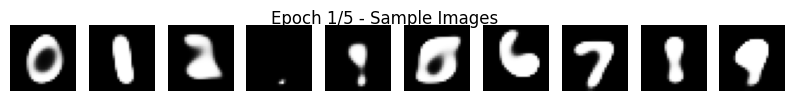

Epoch [2/5], Step [100/469], Loss: 0.6623
Epoch [2/5], Step [200/469], Loss: 0.6432
Epoch [2/5], Step [300/469], Loss: 0.6330
Epoch [2/5], Step [400/469], Loss: 0.6278


<Figure size 640x480 with 0 Axes>

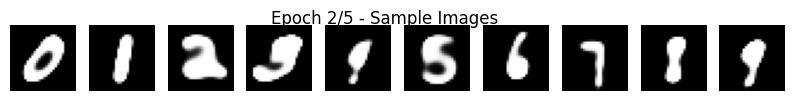

Epoch [3/5], Step [100/469], Loss: 0.6037
Epoch [3/5], Step [200/469], Loss: 0.6397
Epoch [3/5], Step [300/469], Loss: 0.6424
Epoch [3/5], Step [400/469], Loss: 0.6119


<Figure size 640x480 with 0 Axes>

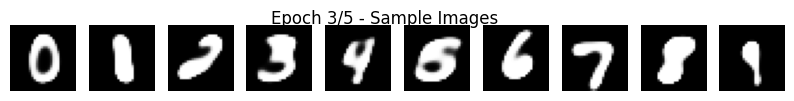

Epoch [4/5], Step [100/469], Loss: 0.6248
Epoch [4/5], Step [200/469], Loss: 0.6050
Epoch [4/5], Step [300/469], Loss: 0.6158
Epoch [4/5], Step [400/469], Loss: 0.6118


<Figure size 640x480 with 0 Axes>

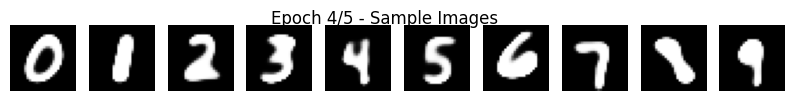

Epoch [5/5], Step [100/469], Loss: 0.6228
Epoch [5/5], Step [200/469], Loss: 0.6343
Epoch [5/5], Step [300/469], Loss: 0.6305
Epoch [5/5], Step [400/469], Loss: 0.6701


<Figure size 640x480 with 0 Axes>

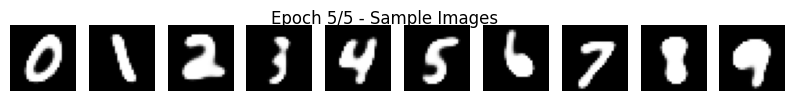

<Figure size 640x480 with 0 Axes>

In [11]:
# train the VAE model
training_losses = train(vae, optimizer, EPOCHS, trainloader, device, loss_type='total_loss')

### Task 1.3: Plot the training curve for the VAE model

In [12]:
# Task 1.3 Plot the training curve (loss) of the VAE model with steps on x-axis and loss on y-axis

def plot_loss_curve(training_losses, figsize=(5, 3), file_name='training_loss_curve'):
    """ Plot the training loss curve."""
    plt.figure(figsize=figsize)
    plt.plot(training_losses)
    plt.title('Training Loss Curve')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.tight_layout()
    plt.show()
    plt.savefig(RESULTS_DIR + file_name + '.png')

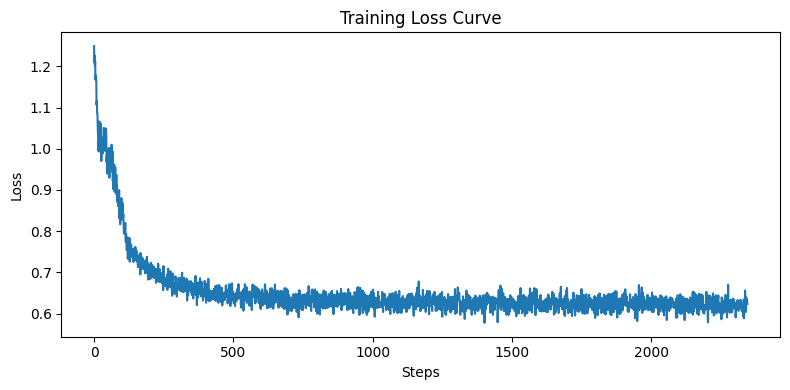

<Figure size 640x480 with 0 Axes>

In [13]:
# Plot the training curve
plot_loss_curve(training_losses, figsize=(8, 4), file_name='vae_training_loss_curve')

## Task 2: Visualize the latent space


### Task 2.1: Train VAE with MSE Loss

Epoch [1/5], Step [100/469], Loss: 0.7909
Epoch [1/5], Step [200/469], Loss: 0.7009
Epoch [1/5], Step [300/469], Loss: 0.6907
Epoch [1/5], Step [400/469], Loss: 0.6768


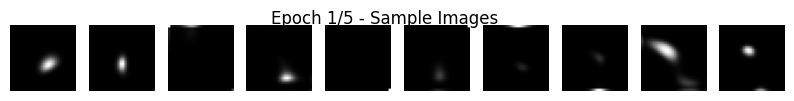

Epoch [2/5], Step [100/469], Loss: 0.6432
Epoch [2/5], Step [200/469], Loss: 0.6248
Epoch [2/5], Step [300/469], Loss: 0.6246
Epoch [2/5], Step [400/469], Loss: 0.6220


<Figure size 640x480 with 0 Axes>

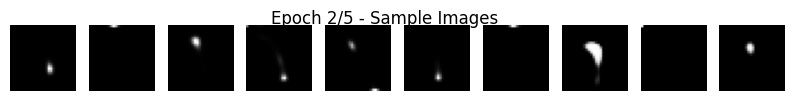

Epoch [3/5], Step [100/469], Loss: 0.6095
Epoch [3/5], Step [200/469], Loss: 0.6314
Epoch [3/5], Step [300/469], Loss: 0.6163
Epoch [3/5], Step [400/469], Loss: 0.6289


<Figure size 640x480 with 0 Axes>

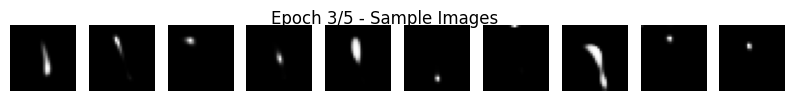

Epoch [4/5], Step [100/469], Loss: 0.6148
Epoch [4/5], Step [200/469], Loss: 0.6402
Epoch [4/5], Step [300/469], Loss: 0.5900
Epoch [4/5], Step [400/469], Loss: 0.6152


<Figure size 640x480 with 0 Axes>

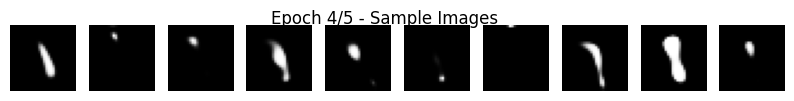

In [14]:
# Task 2.1 train VAE again using only reconstruction loss
vae_rec = VAE(latent_dim=2).to(device)

optimizer = torch.optim.Adam(vae_rec.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# train the VAE model only with MSE reconstruction loss
training_losses = train(vae_rec, optimizer, EPOCHS, trainloader, device, loss_type='mse_loss')

# Plot the training curve
plot_loss_curve(training_losses, figsize=(8, 5), file_name='vae_mse_rec_training_loss_curve')

### Task 2.1.1: Train VAE with BCE Loss

In [ ]:
# Task 2.1 train VAE again using only reconstruction loss
vae_rec = VAE(latent_dim=2).to(device)

optimizer = torch.optim.Adam(vae_rec.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# train the VAE model only with BCE reconstruction loss
training_losses = train(vae_rec, optimizer, EPOCHS, trainloader, device, loss_type='bce_loss')

# Plot the training curve
plot_loss_curve(training_losses, figsize=(8, 5), file_name='vae_bce_rec_training_loss_curve')

ValueError: Invalid loss type. Choose from ['total_loss', 'reconstruction_loss', 'regularization_loss']

### Task 2.1.2: Train VAE with KL Loss

Epoch [1/5], Step [10/469], Loss: 0.4790
Epoch [1/5], Step [20/469], Loss: 0.1476
Epoch [1/5], Step [30/469], Loss: 0.0666
Epoch [1/5], Step [40/469], Loss: 0.0305
Epoch [1/5], Step [50/469], Loss: 0.0205
Epoch [1/5], Step [60/469], Loss: 0.0133
Epoch [1/5], Step [70/469], Loss: 0.0093
Epoch [1/5], Step [80/469], Loss: 0.0088
Epoch [1/5], Step [90/469], Loss: 0.0068
Epoch [1/5], Step [100/469], Loss: 0.0061
Epoch [1/5], Step [110/469], Loss: 0.0063
Epoch [1/5], Step [120/469], Loss: 0.0054
Epoch [1/5], Step [130/469], Loss: 0.0045
Epoch [1/5], Step [140/469], Loss: 0.0041
Epoch [1/5], Step [150/469], Loss: 0.0042
Epoch [1/5], Step [160/469], Loss: 0.0033
Epoch [1/5], Step [170/469], Loss: 0.0033
Epoch [1/5], Step [180/469], Loss: 0.0026
Epoch [1/5], Step [190/469], Loss: 0.0030
Epoch [1/5], Step [200/469], Loss: 0.0029
Epoch [1/5], Step [210/469], Loss: 0.0019
Epoch [1/5], Step [220/469], Loss: 0.0022
Epoch [1/5], Step [230/469], Loss: 0.0020
Epoch [1/5], Step [240/469], Loss: 0.0020
E

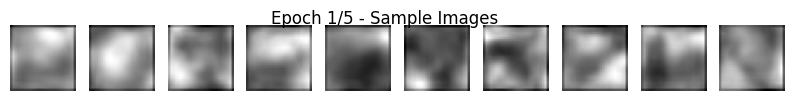

Epoch [2/5], Step [10/469], Loss: 0.0006
Epoch [2/5], Step [20/469], Loss: 0.0006
Epoch [2/5], Step [30/469], Loss: 0.0006
Epoch [2/5], Step [40/469], Loss: 0.0006
Epoch [2/5], Step [50/469], Loss: 0.0005
Epoch [2/5], Step [60/469], Loss: 0.0006
Epoch [2/5], Step [70/469], Loss: 0.0005
Epoch [2/5], Step [80/469], Loss: 0.0004
Epoch [2/5], Step [90/469], Loss: 0.0004
Epoch [2/5], Step [100/469], Loss: 0.0004
Epoch [2/5], Step [110/469], Loss: 0.0004
Epoch [2/5], Step [120/469], Loss: 0.0004
Epoch [2/5], Step [130/469], Loss: 0.0004
Epoch [2/5], Step [140/469], Loss: 0.0004
Epoch [2/5], Step [150/469], Loss: 0.0004
Epoch [2/5], Step [160/469], Loss: 0.0004
Epoch [2/5], Step [170/469], Loss: 0.0003
Epoch [2/5], Step [180/469], Loss: 0.0003
Epoch [2/5], Step [190/469], Loss: 0.0003
Epoch [2/5], Step [200/469], Loss: 0.0003
Epoch [2/5], Step [210/469], Loss: 0.0003
Epoch [2/5], Step [220/469], Loss: 0.0003
Epoch [2/5], Step [230/469], Loss: 0.0003
Epoch [2/5], Step [240/469], Loss: 0.0003
E

<Figure size 640x480 with 0 Axes>

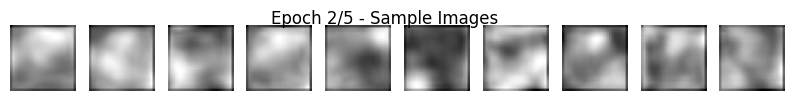

Epoch [3/5], Step [10/469], Loss: 0.0001
Epoch [3/5], Step [20/469], Loss: 0.0001
Epoch [3/5], Step [30/469], Loss: 0.0001
Epoch [3/5], Step [40/469], Loss: 0.0001
Epoch [3/5], Step [50/469], Loss: 0.0001
Epoch [3/5], Step [60/469], Loss: 0.0001
Epoch [3/5], Step [70/469], Loss: 0.0001
Epoch [3/5], Step [80/469], Loss: 0.0001
Epoch [3/5], Step [90/469], Loss: 0.0001
Epoch [3/5], Step [100/469], Loss: 0.0001
Epoch [3/5], Step [110/469], Loss: 0.0001
Epoch [3/5], Step [120/469], Loss: 0.0001
Epoch [3/5], Step [130/469], Loss: 0.0001
Epoch [3/5], Step [140/469], Loss: 0.0001
Epoch [3/5], Step [150/469], Loss: 0.0001
Epoch [3/5], Step [160/469], Loss: 0.0001
Epoch [3/5], Step [170/469], Loss: 0.0001
Epoch [3/5], Step [180/469], Loss: 0.0001
Epoch [3/5], Step [190/469], Loss: 0.0001
Epoch [3/5], Step [200/469], Loss: 0.0001
Epoch [3/5], Step [210/469], Loss: 0.0001
Epoch [3/5], Step [220/469], Loss: 0.0001
Epoch [3/5], Step [230/469], Loss: 0.0001
Epoch [3/5], Step [240/469], Loss: 0.0001
E

<Figure size 640x480 with 0 Axes>

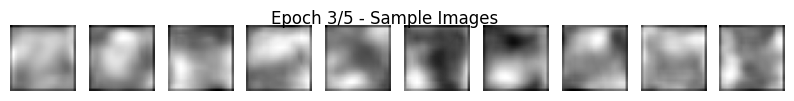

Epoch [4/5], Step [10/469], Loss: 0.0000
Epoch [4/5], Step [20/469], Loss: 0.0000
Epoch [4/5], Step [30/469], Loss: 0.0000
Epoch [4/5], Step [40/469], Loss: 0.0000
Epoch [4/5], Step [50/469], Loss: 0.0000
Epoch [4/5], Step [60/469], Loss: 0.0000
Epoch [4/5], Step [70/469], Loss: 0.0000
Epoch [4/5], Step [80/469], Loss: 0.0000
Epoch [4/5], Step [90/469], Loss: 0.0000
Epoch [4/5], Step [100/469], Loss: 0.0000
Epoch [4/5], Step [110/469], Loss: 0.0000
Epoch [4/5], Step [120/469], Loss: 0.0000
Epoch [4/5], Step [130/469], Loss: 0.0000
Epoch [4/5], Step [140/469], Loss: 0.0000
Epoch [4/5], Step [150/469], Loss: 0.0000
Epoch [4/5], Step [160/469], Loss: 0.0000
Epoch [4/5], Step [170/469], Loss: 0.0000
Epoch [4/5], Step [180/469], Loss: 0.0000
Epoch [4/5], Step [190/469], Loss: 0.0000
Epoch [4/5], Step [200/469], Loss: 0.0000
Epoch [4/5], Step [210/469], Loss: 0.0000
Epoch [4/5], Step [220/469], Loss: 0.0000
Epoch [4/5], Step [230/469], Loss: 0.0000
Epoch [4/5], Step [240/469], Loss: 0.0000
E

<Figure size 640x480 with 0 Axes>

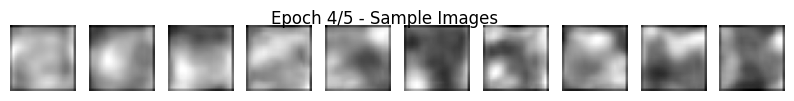

Epoch [5/5], Step [10/469], Loss: 0.0000
Epoch [5/5], Step [20/469], Loss: 0.0000
Epoch [5/5], Step [30/469], Loss: 0.0000
Epoch [5/5], Step [40/469], Loss: 0.0000
Epoch [5/5], Step [50/469], Loss: 0.0000
Epoch [5/5], Step [60/469], Loss: 0.0000
Epoch [5/5], Step [70/469], Loss: 0.0000
Epoch [5/5], Step [80/469], Loss: 0.0000
Epoch [5/5], Step [90/469], Loss: 0.0000
Epoch [5/5], Step [100/469], Loss: 0.0000
Epoch [5/5], Step [110/469], Loss: 0.0000
Epoch [5/5], Step [120/469], Loss: 0.0000
Epoch [5/5], Step [130/469], Loss: 0.0000
Epoch [5/5], Step [140/469], Loss: 0.0000
Epoch [5/5], Step [150/469], Loss: 0.0000
Epoch [5/5], Step [160/469], Loss: 0.0000
Epoch [5/5], Step [170/469], Loss: 0.0000
Epoch [5/5], Step [180/469], Loss: 0.0000
Epoch [5/5], Step [190/469], Loss: 0.0000
Epoch [5/5], Step [200/469], Loss: 0.0000
Epoch [5/5], Step [210/469], Loss: 0.0000
Epoch [5/5], Step [220/469], Loss: 0.0000
Epoch [5/5], Step [230/469], Loss: 0.0000
Epoch [5/5], Step [240/469], Loss: 0.0000
E

<Figure size 640x480 with 0 Axes>

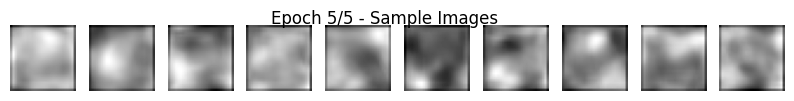

<Figure size 640x480 with 0 Axes>

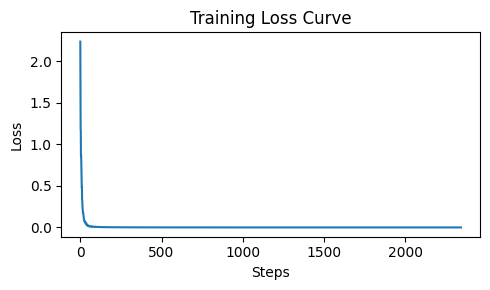

<Figure size 640x480 with 0 Axes>

In [ ]:
# Task 2.2 train VAE again using only regularization loss (KL-divergence)
vae_reg = VAE(latent_dim=2).to(device)

# Implement the ADAM optimizer
optimizer = torch.optim.Adam(vae_reg.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Train the model
training_losses = train(vae_reg, optimizer, EPOCHS, trainloader, device, loss_type='kl_loss')

# Plot the training curve
plot_loss_curve(training_losses, figsize=(8, 5), file_name='vae_reg_training_loss_curve')

**What can you observe?**

Training only with KL-Loss
* The KL-Loss term structures the latent space
* VAE focuses only on making latent space distribution match the prior (standard normal distribution)
* This leads to very blurry output images since KL-Divergence encourages the latent space to be as close as possible to the prior distribution which may lead to loss of detail
* Without a reconstruction loss on pixel-level e.g. MSE loss the decoder learns to generate "average" image details that somwhat resemble the training data but lack sharpness and high frequency details since there is no encouragement to learn further image details


### Task 2.3: Train VAE with Total Loss (MSE + KL-Div Loss)

Epoch [1/5], Step [10/469], Loss: 121103.9375
Epoch [1/5], Step [20/469], Loss: 104972.3594
Epoch [1/5], Step [30/469], Loss: 103742.6016
Epoch [1/5], Step [40/469], Loss: 98780.8906
Epoch [1/5], Step [50/469], Loss: 99041.0078
Epoch [1/5], Step [60/469], Loss: 99831.4141
Epoch [1/5], Step [70/469], Loss: 97645.4531
Epoch [1/5], Step [80/469], Loss: 101337.7109
Epoch [1/5], Step [90/469], Loss: 102238.5703
Epoch [1/5], Step [100/469], Loss: 103710.2188
Epoch [1/5], Step [110/469], Loss: 103623.5234
Epoch [1/5], Step [120/469], Loss: 100542.2734
Epoch [1/5], Step [130/469], Loss: 99670.4453
Epoch [1/5], Step [140/469], Loss: 101374.0156
Epoch [1/5], Step [150/469], Loss: 101848.2969
Epoch [1/5], Step [160/469], Loss: 98086.0469
Epoch [1/5], Step [170/469], Loss: 99375.5469
Epoch [1/5], Step [180/469], Loss: 107782.3047
Epoch [1/5], Step [190/469], Loss: 102504.0859
Epoch [1/5], Step [200/469], Loss: 100304.5469
Epoch [1/5], Step [210/469], Loss: 103966.9531
Epoch [1/5], Step [220/469], 

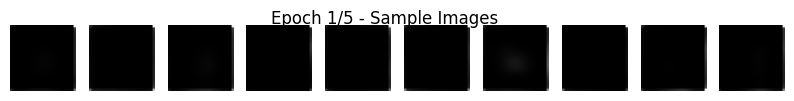

Epoch [2/5], Step [10/469], Loss: 104726.5000
Epoch [2/5], Step [20/469], Loss: 98299.3438
Epoch [2/5], Step [30/469], Loss: 101434.5312
Epoch [2/5], Step [40/469], Loss: 94498.4141
Epoch [2/5], Step [50/469], Loss: 99937.0703
Epoch [2/5], Step [60/469], Loss: 96396.2422
Epoch [2/5], Step [70/469], Loss: 101431.2812
Epoch [2/5], Step [80/469], Loss: 99988.2812
Epoch [2/5], Step [90/469], Loss: 99876.4766
Epoch [2/5], Step [100/469], Loss: 100056.7969
Epoch [2/5], Step [110/469], Loss: 95764.4453
Epoch [2/5], Step [120/469], Loss: 103631.8125
Epoch [2/5], Step [130/469], Loss: 101569.2266
Epoch [2/5], Step [140/469], Loss: 102259.7500
Epoch [2/5], Step [150/469], Loss: 107063.2422
Epoch [2/5], Step [160/469], Loss: 102473.1719
Epoch [2/5], Step [170/469], Loss: 99475.2578
Epoch [2/5], Step [180/469], Loss: 98160.8516
Epoch [2/5], Step [190/469], Loss: 102536.8438
Epoch [2/5], Step [200/469], Loss: 94726.6094
Epoch [2/5], Step [210/469], Loss: 98906.8281
Epoch [2/5], Step [220/469], Loss

<Figure size 640x480 with 0 Axes>

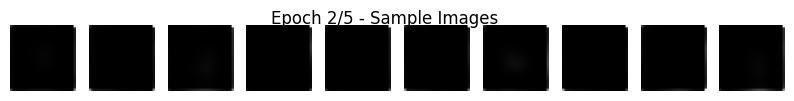

Epoch [3/5], Step [10/469], Loss: 100015.7422
Epoch [3/5], Step [20/469], Loss: 97930.2734
Epoch [3/5], Step [30/469], Loss: 100992.8281
Epoch [3/5], Step [40/469], Loss: 96136.1875
Epoch [3/5], Step [50/469], Loss: 104899.1094
Epoch [3/5], Step [60/469], Loss: 97657.8125
Epoch [3/5], Step [70/469], Loss: 94919.8359
Epoch [3/5], Step [80/469], Loss: 101306.5234
Epoch [3/5], Step [90/469], Loss: 100437.1328
Epoch [3/5], Step [100/469], Loss: 103574.2734
Epoch [3/5], Step [110/469], Loss: 104733.5781
Epoch [3/5], Step [120/469], Loss: 102720.2031
Epoch [3/5], Step [130/469], Loss: 98447.2109
Epoch [3/5], Step [140/469], Loss: 103411.1484
Epoch [3/5], Step [150/469], Loss: 100386.1719
Epoch [3/5], Step [160/469], Loss: 102042.3359
Epoch [3/5], Step [170/469], Loss: 104032.3984
Epoch [3/5], Step [180/469], Loss: 104004.0859
Epoch [3/5], Step [190/469], Loss: 99342.3047
Epoch [3/5], Step [200/469], Loss: 102003.7578
Epoch [3/5], Step [210/469], Loss: 101423.4141
Epoch [3/5], Step [220/469],

<Figure size 640x480 with 0 Axes>

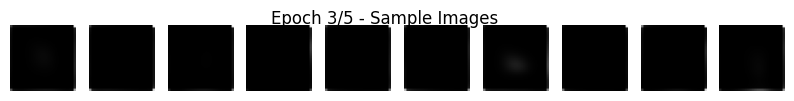

Epoch [4/5], Step [10/469], Loss: 100240.8984
Epoch [4/5], Step [20/469], Loss: 98551.8438
Epoch [4/5], Step [30/469], Loss: 102408.3906
Epoch [4/5], Step [40/469], Loss: 96931.7109
Epoch [4/5], Step [50/469], Loss: 99686.2188
Epoch [4/5], Step [60/469], Loss: 103559.7891
Epoch [4/5], Step [70/469], Loss: 99267.6016
Epoch [4/5], Step [80/469], Loss: 99206.8516
Epoch [4/5], Step [90/469], Loss: 97175.7578
Epoch [4/5], Step [100/469], Loss: 94251.5156
Epoch [4/5], Step [110/469], Loss: 99360.4844
Epoch [4/5], Step [120/469], Loss: 105085.8203
Epoch [4/5], Step [130/469], Loss: 99667.6250
Epoch [4/5], Step [140/469], Loss: 100734.2422
Epoch [4/5], Step [150/469], Loss: 100487.5391
Epoch [4/5], Step [160/469], Loss: 98999.7891
Epoch [4/5], Step [170/469], Loss: 101501.9688
Epoch [4/5], Step [180/469], Loss: 97653.9062
Epoch [4/5], Step [190/469], Loss: 100846.0469
Epoch [4/5], Step [200/469], Loss: 97399.5234
Epoch [4/5], Step [210/469], Loss: 100576.1172
Epoch [4/5], Step [220/469], Loss:

<Figure size 640x480 with 0 Axes>

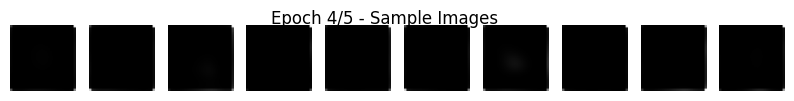

Epoch [5/5], Step [10/469], Loss: 104850.1016
Epoch [5/5], Step [20/469], Loss: 101326.5078
Epoch [5/5], Step [30/469], Loss: 97819.5312
Epoch [5/5], Step [40/469], Loss: 97281.3828
Epoch [5/5], Step [50/469], Loss: 103403.3281
Epoch [5/5], Step [60/469], Loss: 100820.7109
Epoch [5/5], Step [70/469], Loss: 95552.0469
Epoch [5/5], Step [80/469], Loss: 104116.3516
Epoch [5/5], Step [90/469], Loss: 99754.0625
Epoch [5/5], Step [100/469], Loss: 106146.1641
Epoch [5/5], Step [110/469], Loss: 100191.4219
Epoch [5/5], Step [120/469], Loss: 103335.8516
Epoch [5/5], Step [130/469], Loss: 97847.9062
Epoch [5/5], Step [140/469], Loss: 99345.5938
Epoch [5/5], Step [150/469], Loss: 99711.2500
Epoch [5/5], Step [160/469], Loss: 101196.2188
Epoch [5/5], Step [170/469], Loss: 97228.2656
Epoch [5/5], Step [180/469], Loss: 99210.8594
Epoch [5/5], Step [190/469], Loss: 100359.2266
Epoch [5/5], Step [200/469], Loss: 99763.7031
Epoch [5/5], Step [210/469], Loss: 98905.9688
Epoch [5/5], Step [220/469], Loss

<Figure size 640x480 with 0 Axes>

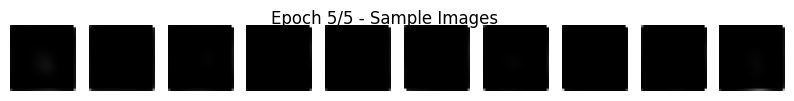

<Figure size 640x480 with 0 Axes>

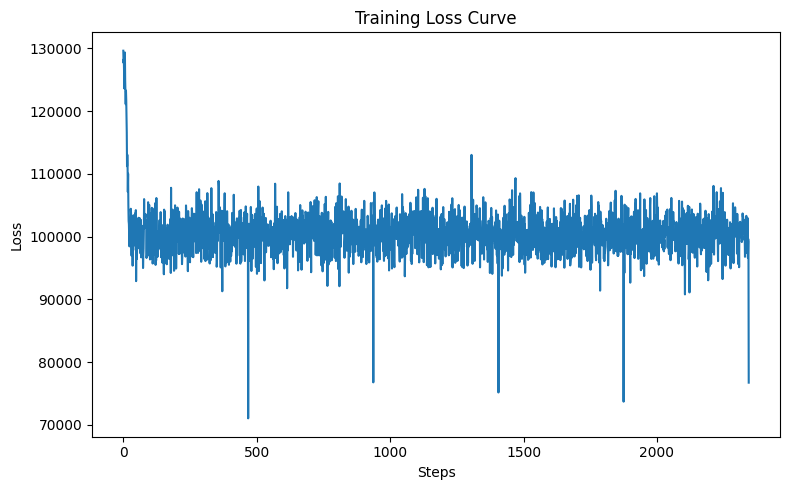

<Figure size 640x480 with 0 Axes>

In [ ]:
# Task 2.3 train VAE again using both reconstruction and regularization loss
vae_t = VAE(latent_dim=2).to(device)


optimizer = torch.optim.Adam(vae_t.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
training_losses = train(vae_t, optimizer, EPOCHS, trainloader, device, loss_type='total_loss')

# Plot the loss curve
plot_loss_curve(training_losses, figsize=(8, 5), file_name='vae_total_training_loss_curve')

In [ ]:
def plot_latent_space(model, dataloader, n=1000, figsize=(10,5), device=None, file_name='vae_latent_space'):
    """ Posterior sampling based on a given MNIST test image. Extract the latent space and plot it using t-SNE.

    Args:
        vae (nn.Module): VAE model.
        dataloader (DataLoader): Dataloader to use for sampling from the true data distribution.
        n (int): Number of samples to plot.
        figsize (int): Size of the figure.
        method (str): Method to use for projecting the latent space to 2D. Should be 'TSNE'.
        device (torch.device): Device to use for tensor operations.

    Returns:
        None
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Set the model to evaluation mode
    model.eval()

    # Sample a large number of points from the true data distribution and encode to obtain latent space samples
    latents = []
    labels = []
    with torch.no_grad():
        for i, (data, label) in enumerate(dataloader):
            if len(latents) >= n:
                break
            data = data.to(device)
            label = label.to(device)
            latent = vae.sample_latent(data, label)
            latents.append(latent)
            labels.append(label)

        latents = torch.concatenate(latents, dim=0)
        labels = torch.concatenate(labels, dim=0)

    # Plot the latent space as a 2D scatter plot
    sns.scatterplot(x=latents[:, 0].cpu().numpy(), y=latents[:, 1].cpu().numpy(), hue=labels.cpu().numpy(), palette='tab10')
    plt.title('Latent Space')
    plt.xlabel('z1')
    plt.ylabel('z2')

    plt.tight_layout()
    plt.show()
    plt.savefig(RESULTS_DIR + file_name + '.png')


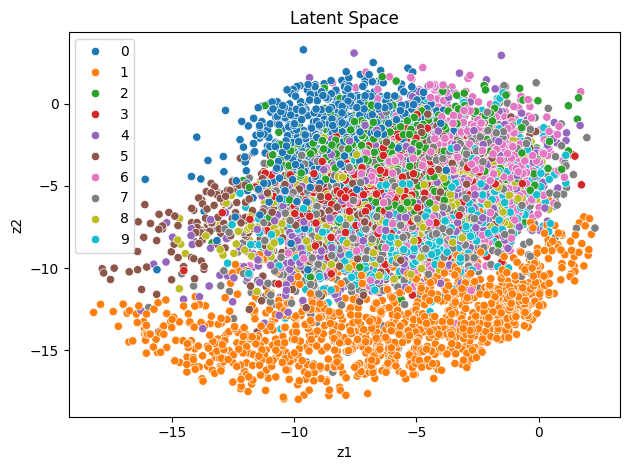

<Figure size 640x480 with 0 Axes>

In [ ]:
# Visualize the latent space
plot_latent_space(vae, testloader, n=1000, figsize=(10,5), device=device, file_name='vae_latent_space')

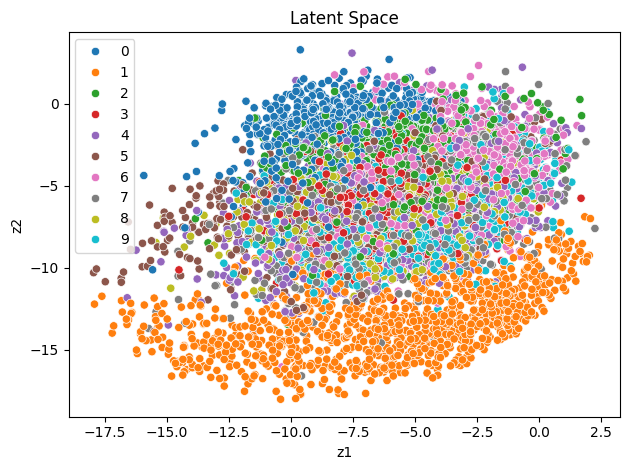

<Figure size 640x480 with 0 Axes>

In [ ]:
# Visualize the latent space for all three models -- reconstruction loss only
plot_latent_space(vae_rec, testloader, n=1000, figsize=(10,5), device=device, file_name='vae_rec_latent_space')

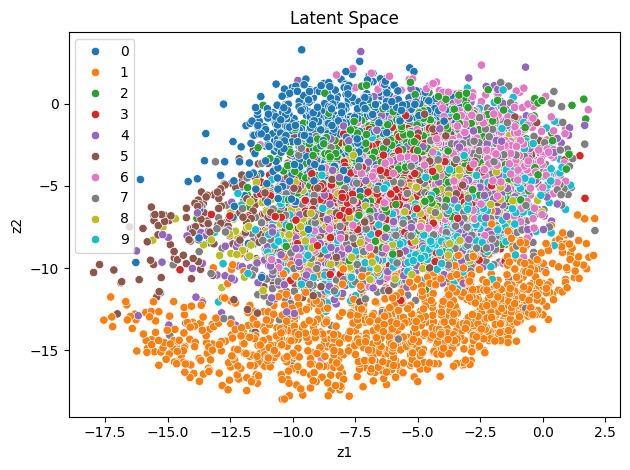

<Figure size 640x480 with 0 Axes>

In [ ]:
# Visualize the latent space for all three models -- regularization loss only
plot_latent_space(vae_reg, testloader, n=1000, figsize=(10,5), device=device, file_name='vae_reg_latent_space')

**Why can we observe a more homegenous distribution of all classes in the above graph using a loss with KL-Divergence only?**

Ideally, we want overlap between samples that are not very similar, in order to interpolate between classes. However, since there are no limits on what values vectors μ and σ can take on, the encoder can learn to generate very different μ for different classes, clustering them apart, and minimize σ, making sure the encodings themselves don’t vary much for the same sample (that is, less uncertainty for the decoder). But what we ideally want are encodings, all of which are as close as possible to each other while still being distinct, allowing smooth interpolation, and enabling the construction of new samples.

In order to force this, we introduce the Kullback–Leibler divergence (KL divergence[2]) into the loss function. The KL divergence between two probability distributions simply measures how much they diverge from each other. Minimizing the KL divergence here means optimizing the probability distribution parameters (μ and σ) to closely resemble that of the target distribution. For VAEs, the KL loss is equivalent to the sum of all the KL divergences between the component Xi~N(μi, σi²) in X, and the standard normal[3]. It’s minimized when μi = 0, σi = 1.


Intuitively, this loss encourages the encoder to distribute all encodings (for all types of inputs, eg. all MNIST numbers), evenly around the center of the latent space. If it tries to “cheat” by clustering them apart into specific regions, away from the origin, it will be penalized. Using purely KL loss results in a latent space with encodings densely placed randomly in Gaussian manner, near the center of the latent space, with little regard for similarity among nearby encodings. Hence, the decoder finds it impossible to decode anything meaningful from this space since there is no meaning encoded.

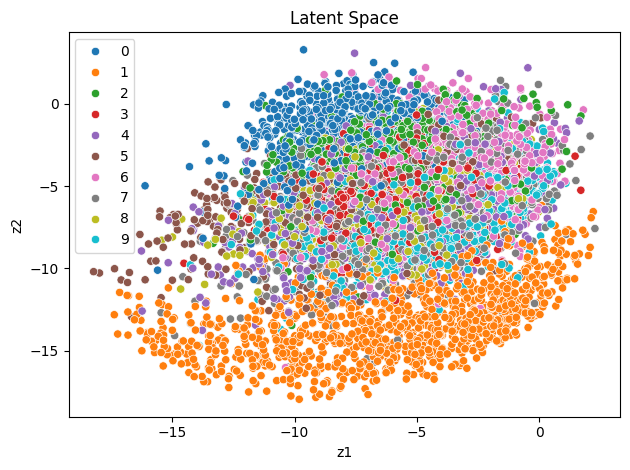

<Figure size 640x480 with 0 Axes>

In [ ]:
# Visualize the latent space -- total loss
plot_latent_space(vae_t, testloader, n=1000, figsize=5, device=device, file_name='vae_t_latent_space')

**Why can we observe more clustering in the latent space using Reconstruction loss with Regularization loss (KL-Divergence)?**

When optimizing the two together, it results in the generation of a latent space which maintains the similarity of nearby encodings on the local scale via clustering, yet globally, is very densely packed near the latent space origin. Intuitively, this is the equilibrium reached by the cluster-forming nature of the reconstruction loss, and the dense packing nature of the KL loss, forming distinct clusters the decoder can decode.

This means, if one samples a vector from the same prior distribution of the encoded vectors, N(0, I), the decoder will successfully decode it. And if you’re interpolating, there are no sudden gaps between clusters, but a smooth mix of features a decoder can understand.

Simply vector arithmetic in the latent space allows to create those smooth interpolations. For example, if you wish to generate a new sample halfway between two samples, just find the difference between their mean (μ) vectors, and add half the difference to the original, and then simply decode it. What about generating specific features, such as generating glasses on a face? Find two samples, one with glasses, one without, obtain their encoded vectors from the encoder, and save the difference. Add this new “glasses” vector to any other face image, and decode it.

In [ ]:
# Plot a grid of samples produced by fixing one latent variable and varying the other

def plot_latent_traversal(vae, device, n=10):
    """ Plot a grid of samples produced by fixing one latent variable and varying the other.

    Args:
        vae (nn.Module): VAE model.
        device (torch.device): Device to use for tensor operations.
        n (int): Number of samples to plot.

    Returns:
        None
    """
    vae.eval()

    # Sample a latent variable based on a standard normal distribution
    z = torch.randn((1, vae.latent_dim), device=device)
    z = z.repeat(n, 1)

    # Plot 10x10 grid of samples
    for i in range(0, n):
        # Select fixed label
        y = torch.tensor([i] * n, device=device)
        
        # Decode the latent variable
        with torch.no_grad():
            samples = vae.decode(z, y)

        # Plot the samples
        plt.figure(figsize=(n, 1))
        for i in range(n):
            plt.subplot(1, n, i + 1)
            plt.imshow(samples[i].squeeze().cpu().numpy(), cmap='gray')
            plt.axis('off')
            # add class label
            plt.title(f'Class: {y[i].item()}')
        plt.show()
        plt.savefig(RESULTS_DIR + f'vae_latent_traversal_{i}.png')


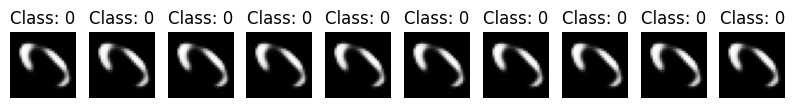

<Figure size 640x480 with 0 Axes>

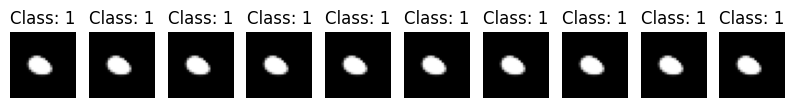

<Figure size 640x480 with 0 Axes>

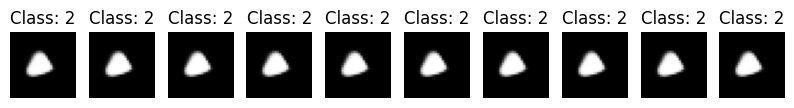

<Figure size 640x480 with 0 Axes>

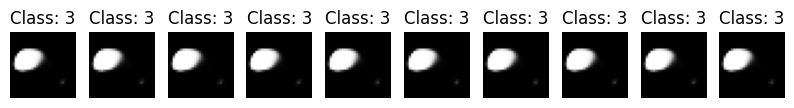

<Figure size 640x480 with 0 Axes>

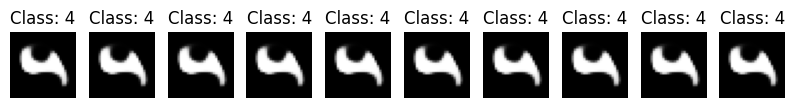

<Figure size 640x480 with 0 Axes>

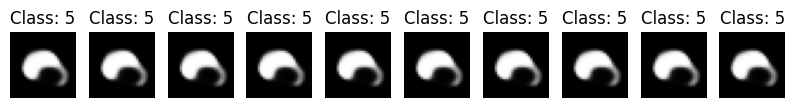

<Figure size 640x480 with 0 Axes>

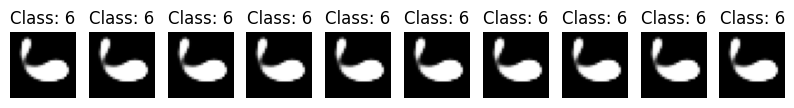

<Figure size 640x480 with 0 Axes>

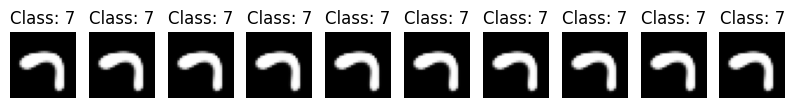

<Figure size 640x480 with 0 Axes>

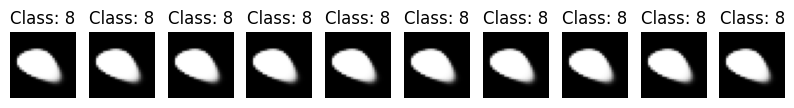

<Figure size 640x480 with 0 Axes>

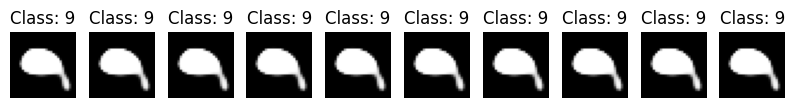

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot the latent traversal
plot_latent_traversal(vae, device, n=10)

## Task 3: Anomaly Detection using a Variational Autoencder


### Task 3.1: Data Preparation for Fashion MNIST Dataset

In [ ]:
# Task 3.1: Download the Fashion MINST dataset
mean = (0.1307,)
std = (0.3081,)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28, 28)),
    transforms.RandomHorizontalFlip(0.2),
    transforms.Normalize(mean, std)])

# Download and load the training dataset
fashion_trainset = datasets.FashionMNIST(DATA_DIR, download=True, train=True, transform=transform)
fashion_trainloader = torch.utils.data.DataLoader(fashion_trainset, batch_size=BATCH_SIZE, shuffle=True)

fashion_testset = datasets.FashionMNIST(DATA_DIR, download=True, train=False, transform=transform)
fashion_testloader = torch.utils.data.DataLoader(fashion_testset, batch_size=BATCH_SIZE, shuffle=False)

100%|██████████| 26421880/26421880 [00:03<00:00, 7480186.19it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 9570535.95it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 7306926.87it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 11216767.27it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



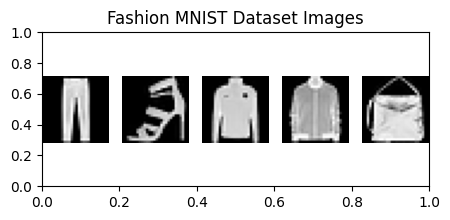

In [ ]:
# Plot 5 sample images from trainloader
plt.figure(figsize=(num_images, 2))
plt.title('Fashion MNIST Dataset Images')

dataiter = iter(fashion_trainloader)
for i in range(num_images):
    images, _ = next(dataiter)

    plt.subplot(1, num_images, i + 1)
    plt.imshow(images[0].numpy().squeeze(), cmap='gray')
    plt.axis('off')

plt.show()
plt.savefig(RESULTS_DIR + 'fashion_mnist_dataset_images.png')

In [ ]:
def compare_reconstruction_loss(vae, fashion_testloader, mnist_testloader, device, file_name='reconstruction_loss_comparison'):
    """ Anomaly detection identifies data points that deviate significantly from the norm
        Compare the reconstruction loss between MNIST and Fashion MNIST datasets.

    Args:
        vae (nn.Module): VAE model.
        trainloader (DataLoader): Training data loader.
        testloader (DataLoader): Test data loader.
        device (torch.device): Which device to use (cuda or cpu).

    Returns:
        None
    """
    vae.eval()
    imgs_mnist = []
    imgs_fashion = []
    rec_loss_mnist = []
    rec_loss_fashion = []

    # Compute the reconstruction loss for MNIST dataset
    for i, (images, labels) in enumerate(mnist_testloader):
        images = images.to(device)
        labels = labels.to(device)
        x_recon, mean, log_var = vae(images, labels)
        loss = reconstruction_loss(images, x_recon)
        rec_loss_mnist.append(loss.item())
        imgs_mnist.append(images.cpu().detach().numpy())

    # Compute the reconstruction loss for Fashion MNIST dataset
    for i, (images, labels) in enumerate(fashion_testloader):
        images = images.to(device)
        labels = labels.to(device)
        x_recon, mean, log_var = vae(images, labels)
        loss = reconstruction_loss(images, x_recon)
        rec_loss_fashion.append(loss.item())
        imgs_fashion.append(images.cpu().detach().numpy())

    # Plot 10 sample MNIST images and their corresponding reconstruction loss values
    fig, axs = plt.subplots(2, figsize=(10, 5))
    fig.suptitle('MNIST Dataset Images and Reconstruction Loss')

    # Bar chart of reconstruction loss
    axs[0].bar(range(1, 11), rec_loss_mnist[:10])
    axs[0].set_xlabel('Image Index')
    axs[0].set_ylabel('Reconstruction Loss')
    axs[0].set_xticks(range(1, 11))
    # set range for y-axis
    axs[0].set_ylim([0, 120000])

    # Plot a line on top of the bar chart in red connecting each chart element
    axs[0].plot(range(1, 11), rec_loss_mnist[:10], color='red', linewidth=2)

    # MNIST images and their corresponding reconstruction loss values
    for i in range(10):
        ax = plt.subplot(1, 10, i + 1) # create a subplot for each image
        ax.imshow(imgs_mnist[i][0].squeeze(), cmap='gray')
        ax.text(0.5, -0.1, f'Rec. Loss: {rec_loss_mnist[i]:.2f}', ha='center', fontsize=4, color='w', transform=ax.transAxes) # display the reconstruction loss value below the image
        ax.axis('off')

    plt.savefig(f'results/{file_name}_mnist.png')
    plt.show()

    # Plot 10 sample Fashion MNIST images and their corresponding reconstruction loss values
    fig, axs = plt.subplots(2, figsize=(10, 5))
    fig.suptitle('Fashion MNIST Dataset Images and Reconstruction Loss')

    # Bar chart of reconstruction loss
    axs[0].bar(range(1, 11), rec_loss_fashion[:10])
    axs[0].set_xlabel('Image Index')
    axs[0].set_ylabel('Reconstruction Loss')
    axs[0].set_xticks(range(1, 11))
    # set range for y-axis
    axs[0].set_ylim([0, 120000])

    # Plot a line on top of the bar chart in red connecting each chart element
    axs[0].plot(range(1, 11), rec_loss_fashion[:10], color='red', linewidth=2)

    # Fashion MNIST images and their corresponding reconstruction loss values
    for i in range(10):
        ax = plt.subplot(1, 10, i + 1) # create a subplot for each image
        ax.imshow(imgs_fashion[i][0].squeeze(), cmap='gray')
        ax.text(0.5, -0.1, f'Rec. Loss: {rec_loss_fashion[i]:.2f}', ha='center', fontsize=4, color='w', transform=ax.transAxes)
        ax.axis('off')

    plt.savefig(f'results/{file_name}_fashion_mnist.png')
    plt.show()


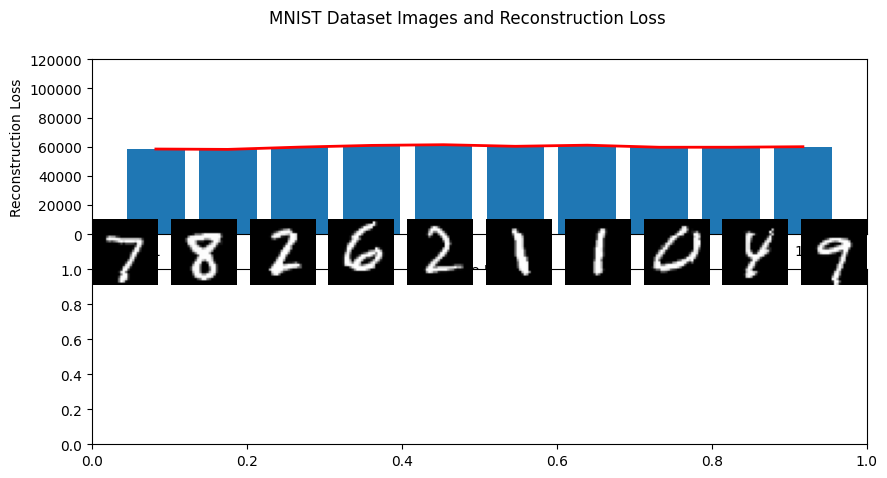

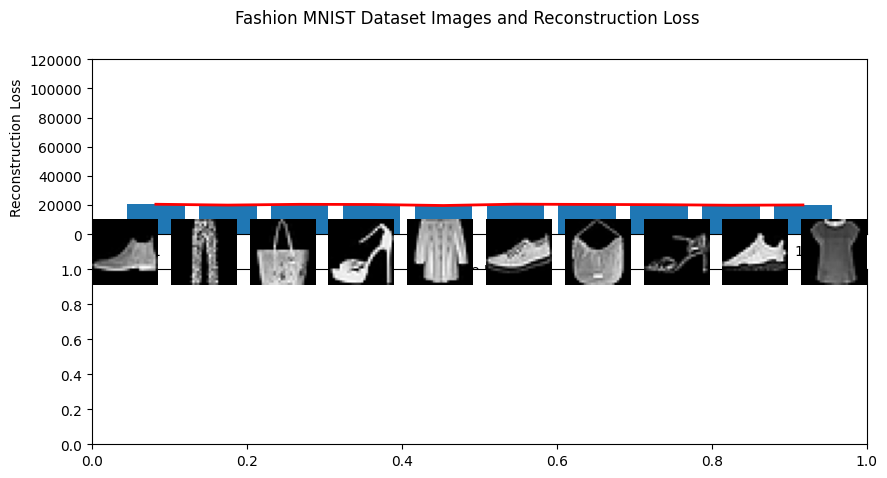

In [ ]:
# Compare the reconstruction loss between MNIST and Fashion MNIST datasets
# Use samples from MNIST handwritten digit dataset and the MNIST. fashion dataset to showcase the difference in reconstruction loss. Plot 10 samples of each dataset and their corresponding reconstruction loss.
compare_reconstruction_loss(vae, fashion_testloader, testloader, device, file_name='reconstruction_loss_comparison')